TODO's:
- Fix the inflow to ETCs!!
- Random travel to non-neighbouring regions
- Removal of ETCs possible
- Constraints for decision-making


### Constants ###

In [2]:
fat_without = 0.4 #proportion of people dying without treatment
t_fat_without = 0.9 #time in weeks until death without treatment
t_rec_without = 2.5 #time in weeks until recovery without treatment

fat_with = 0.35 #proportion of people dying with treatment
t_fat_with = 1 #time in weeks until death with treatment
t_rec_with = 1.56 #time in weeks until recovery with treatment
safe_b_rate =0.73 #proportion of burials that are conducted safely



compartments = 6 #no. of compartments in the model
i_index = 1 #when listing the compartments, where the infected compartent is (starting from 0)

regions_list = [0,1,2,3] #list of the regions

#Exploration vs Exploitation ratio
explore = 0.5

### Objects ###

In [16]:
import random

class Uncertain_Constant:
    def __init__(self, ground_truth, variable_range):
        self.ground_truth = ground_truth
        self.variable_range = variable_range  #[value, value]
        self.original_range = variable_range
        self.percentage = 1.0
        
        
        
    def fuzzifier(self):
        new_width = (self.original_range[1] - self.original_range[0]) * self.percentage

        in_current_range = False

        
        while in_current_range == False:
            z = new_width * random.uniform(0,1)
            new_range = [self.ground_truth - (new_width - z), self.ground_truth + z]


            if new_range[0] >= 0:
                self.variable_range = new_range
                in_current_range = True
                
    def reduce_uncertainty(self, percentage):
        self.percentage = percentage
        self.fuzzifier()

class Uncertain_Variable:
    def __init__(self, ground_truth, variable_width):
        self.ground_truth = ground_truth
        self.variable_width = variable_width
        self.percentage = 1.0
        self.current_range =0
        
        self.fuzzifier()
        
    def fuzzifier(self):
        new_range_width = self.variable_width * self.percentage * self.ground_truth
        valid_range = False
        while valid_range == False:
            z = new_range_width * random.uniform(0,1)
            new_range  = [self.ground_truth - (new_range_width - z), self.ground_truth + z]

            if new_range[0] >= 0:
                self.current_range = new_range
                valid_range = True
                
    def reduce_uncertainty(self, percentage):
        self.percentage = percentage
        self.fuzzifier()
        
    def new_truth(self, ground_truth):
        self.ground_truth = ground_truth
        self.fuzzifier()
        

        
class Region:
    def __init__(self, number, susceptible, infected, recovered, deceased, funeral, treated, 
                 beta_i, beta_d, ETC_cap):
        self.number = number
        self.susceptible = susceptible
        self.infected = infected
        self.recovered = recovered
        self.deceased = deceased
        self.funeral = funeral
        self.treated = treated
        self.beta_i = beta_i
        self.beta_d = beta_d
        self.ETC_cap = ETC_cap
        #TO-DO: ranges are now hardcoded
        self.uncertain_I = Uncertain_Variable(infected, 2.5)
        self.uncertain_bi = Uncertain_Constant(beta_i, [0.06,0.4])
        
        self.ETCs = []
        self.cummulative_patients = 0
        
    
    def update(self,compartments_list):
        self.susceptible, self.infected, self.recovered, self.deceased, self.funeral, self.treated = compartments_list
        self.uncertain_I.new_truth(self.infected)
        
        
        
    def placement_decision(self, timestep, capacity):
        self.ETCs.append([timestep, capacity])
        
    def calculate_capacity(self, timestep):
        for decision in self.ETCs:
            capacity = decision[1]
            if capacity == 10 and decision[0] + 1 == timestep:

                self.ETC_cap += 10
            elif capacity == 50 and decision[0] + 3 == timestep:

                self.ETC_cap += 50

### Helper functions ###

In [18]:
### Functions for the Uncertainty Reduction ###
import math

def unc_infected(region, timestep):
    
    ETC_50 = [1.0,0.95,0.85,0.7,0.5,0.325,0.25,0.225,0.21,0.2]
    ETC_10 = [1,0.95,0.7,0.55,0.45,0.375,0.325,0.30]

    perc_reduced = 1.0
    ETCs = region.ETCs
    for ETC in ETCs:
        if ETC[1] == 50:
            weeks = timestep - ETC[0]
            
            if weeks >= len(ETC_50):
                percentage = ETC_50[9]
            else:
                percentage = ETC_50[weeks]
                
            if perc_reduced > percentage:
                perc_reduced = percentage
                
        elif ETC[1] == 10:
            weeks = timestep - ETC[0]
            
            if weeks >= len(ETC_10):
                percentage = ETC_10[7]
            else:
                percentage = ETC_10[weeks]
                
            if perc_reduced > percentage:
                perc_reduced = percentage

    return perc_reduced
        

def unc_transmission(cumm_patients):
    if cumm_patients > 100:
        return 100
    else:
        return math.e**(-cumm_patients/15)

In [19]:
### Function to Determine the Neighbouring Regions ###

import math

def get_neighbours(i,square_list):
    l = len(square_list)
    row = math.sqrt(l)

    if(i < row):
            #this is the top row

        if(i == 0):
            #it's the first entry of the row
            neighbours = [i+1,i+row]
        elif(i == row-1):
            #it's the last entry of the row
            neighbours = [i-1,i+row]
        else:
            neighbours = [i-1, i+1, i+row]
            
    elif(i > l-1-row):
            #this is the bottom row

        if(i == l-row):
            #it's the first entry of the row
            neighbours = [i+1, i-row]
        elif (i == l-1):
            #it's the last entry of the row
            neighbours = [i-1, i-row]
        else:
            neighbours = [i-1, i+1, i-row]

    else:
            #it's a middle row 

        if (i % row == 0):    
            #it's the first entry of a row
            neighbours = [i+1, i-row, i+row]
        elif (i % row == (row-1)):
            #it's the last entry of a row
            neighbours = [i-1, i-row, i+row]
        else:
            #it's a "middle" entry
            neighbours = [i-1,i+1,i-row,i+row]
    
    return neighbours
        
    

In [30]:
### Decision-making functions ###


def explorative_decision(regions,x):
        options = []
        highest_uncertainty = 0
            
        for region in regions:
                    
            uncertainty = unc_infected(region, x) + unc_transmission(region.cummulative_patients)
                
            if uncertainty > highest_uncertainty:
                highest_uncertainty = uncertainty
                options = [region]
            elif uncertainty == highest_uncertainty:
                options.append(region)
                    
        #if there are multiple region with the same level of uncertainty, choose one at random            
        if len(options) != 1:
                chosen_region = random.choice(options)
        else:
                chosen_region = options[0]
                
        #For now, we always place a small ETC because this gives the fastest reduction.
        chosen_region.placement_decision(x,10)
        print("I'm making an explorative decision to place a small ETC in region ", chosen_region.number)
        
def exploitative_decision(regions,x):
        #beta_i*infected * (susceptible /(susceptible + infected) (for now we don't take into account the deceased/funerals)
            
        highest_infected = 0
        options = []
            
        for region in regions:
                
            #conservative choice: choose the region with the highest no of infections according to the lower bound
            #for the next timestep
            infected = region.uncertain_I.current_range[0] + region.uncertain_I.current_range[0] * region.uncertain_bi.variable_range[0] * (10000 / (10000 + region.uncertain_I.current_range[0]))

                
            if infected > highest_infected:
                highest_infected = infected
                options = [region]
            elif infected == highest_infected:
                options.append(region)
        
        #if there are multiple regions with the same number of infected people, choose one at random
        if len(options) != 1:
            chosen_region = random.choice(options)
        else:
            chosen_region = options[0]
                
        if highest_infected >= 50:
            chosen_region.placement_decision(x,50)
            print("I'm making an exploitaive decision to place a big ETC in region", chosen_region.number)
        else:
            chosen_region.placement_decision(x,10)
            print("I'm making an exploitaive decision to place a small ETC in region", chosen_region.number)

In [21]:
### Helper functions for the Compartmental Model ###

#change in susceptible people
def f_dsdt(susceptible, infected, deceased, beta_i, beta_d):
    return -(beta_i*infected + beta_d*deceased) * (susceptible /(susceptible + infected))

#change in recovered people
def f_drdt(infected, treated):
    return ((1-fat_without)*infected) / t_rec_without + (1-fat_with)*treated / t_rec_with

#change in infected people
#with travelling
def f_didt(susceptible, infected, deceased, treated, neighbours, no_neighbours, beta_i, beta_d, travel_rate, ETC_cap):
    if treated < ETC_cap:
        return ((beta_i*infected + beta_d*deceased) * (susceptible /(susceptible + infected))
                + travel_rate * neighbours
                - no_neighbours * travel_rate * infected
            - ((1 - fat_without)*infected) / t_rec_without
           - fat_without*infected / t_fat_without
            - min(ETC_cap - treated, infected)) 
    else:
        return ((beta_i*infected + beta_d*deceased) * (susceptible /(susceptible + infected))
                + travel_rate * neighbours
                - no_neighbours * travel_rate *infected
               - ((1-fat_without)*infected) / t_rec_without
               - fat_without*infected / t_fat_without)

#change in treated people
#TO-DO: Something's going wrong: only ~28 people enter the ETC when it opens (instead of full capacity)
def f_dtrdt(infected, treated, ETC_cap):
    if treated < ETC_cap:
        return min(ETC_cap - treated, infected) -(1-fat_with)*treated / t_rec_with - fat_with*treated / t_fat_with
    else:
        return -(1-fat_with)*treated / t_rec_with - fat_with*treated / t_fat_with

    
#change in deceased people
def f_dddt(infected, treated, deceased):
    return (fat_without*infected) / t_fat_without + fat_with*treated / t_fat_with - deceased * safe_b_rate

def f_dfdt(deceased):
    return deceased * safe_b_rate

### Compartmental Model ###

In [22]:
def calc_population(y,t, region1, region2, region3, region4, travel_rate):
    
    dydt = []
    
    regions = [region1, region2, region3, region4]
    
    #we have a long list of regions, loop over them 
    for i in range(0,len(regions)):
    
        #here we grab the compartments for every region
        susceptible, infected, recovered, deceased, funeral, treated = y[i*compartments:i*compartments+compartments]
        
        #and get the (number of) neighbours
        neighbouring_regions = get_neighbours(i,regions_list)
        no_neighbours = len(neighbouring_regions)
        
        neighbours = 0;
        
        #how many infected individuals there are in the neighbouring regions
        for j in range(0,len(neighbouring_regions)):
            region = neighbouring_regions[j]
            
            neighbours += y[int(region*compartments+i_index)]
            
        #grab the parameters from the region objects
        beta_i = regions[i].beta_i
        beta_d = regions[i].beta_d
        
        ETC_cap = regions[i].ETC_cap
        


        #update all the compartments of the region accordingly
        dsdt = f_dsdt(susceptible, infected, deceased, beta_i, beta_d)

        didt = f_didt(susceptible, infected, deceased, treated, neighbours, no_neighbours, beta_i, beta_d, travel_rate, ETC_cap)



        drdt = f_drdt(infected, treated)

        dddt = f_dddt(infected, treated, deceased)
        dfdt = f_dfdt(deceased)
            
        dtrdt = f_dtrdt(infected, treated, ETC_cap)
        
        #and append the outcomes to the list that the function will return
        dydt.extend([dsdt,didt,drdt,dddt,dfdt,dtrdt])
        
        #also update the number of cummulative patients for that region:
        regions[i].cummulative_patients += dtrdt

    

    return dydt

### General Ebola Model ###

In [31]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

def ebola_model(I1 = 0,
                I2 = 0,
                I3 = 0,
                I4 = 0,
                beta_i1 = 0.33,
                beta_i2 = 0.33,
                beta_i3 = 0.33,
                beta_i4 = 0.33,
                beta_d = 0.68,
                travel_rate = 0.05):
    
    time_vec = np.linspace(0,1,2)
    


    region1 = Region(1, (10000-1.5*I1), I1, 0, (0.5*I1), 0, 0, beta_i1, beta_d, 0)
    region2 = Region(2, 10000-1.5*I2, I2, 0, 0.5*I2, 0, 0, 
                 beta_i2, beta_d, 0)
    region3 = Region(3, 10000-1.5*I3, I3, 0, 0.5*I3, 0, 0, 
                 beta_i3, beta_d, 0)
    region4 = Region(4, 10000-1.5*I4, I4, 0, 0.5*I4, 0, 0, 
                 beta_i4, beta_d, 0)
    
    regions = [region1, region2, region3, region4]
    
    y0 = []
    
    for region in regions:
        y0.extend([region.susceptible, region.infected, region.recovered, region.deceased, region.funeral, region.treated])

    
    S1 = []
    I1 = []
    R1 = []
    D1 = []
    F1 = []
    T1 = []
    
    S2 = []
    I2 = []
    R2 = []
    D2 = []
    F2 = []
    T2 = []
        
    S3 = []
    I3 = []
    R3 = []
    D3 = []
    F3 = []
    T3 = []
    
    S4 = []
    I4 = []
    R4 = []
    D4 = []
    F4 = []
    T4 = []
    
    for x in range (0,10):
        
        print("Timestep ", x)
        
        for region in regions:                       
            #update uncertainties
            if region.uncertain_I.percentage != unc_infected(region,x):
                region.uncertain_I.reduce_uncertainty(unc_infected(region, x))
                
            if region.uncertain_bi.percentage != unc_transmission(region.cummulative_patients):
                region.uncertain_bi.reduce_uncertainty(unc_transmission(region.cummulative_patients))
            
            
        
        #make decisions
        decision_type  = random.uniform(0,1)
        if decision_type < explore:
            
            #take an explorative action
            explorative_decision(regions,x)

        else:
            #take an exploitative action
            exploitative_decision(regions,x)

            
        #update the ETC capacity of each region
        for region in regions:
            region.calculate_capacity(x)
        
        #Run the compartmental model for 1 timestep                                                                                  
        population = odeint(calc_population, y0, t=time_vec, args=(region1, region2, region3, region4, travel_rate))
        
        #grab the states of the compartments at the end of the timestep
        y0 = population.T[:,1]
       
        #need to store the outcomes for each timestep
        S1.append(y0[0])
        I1.append(y0[1])
        R1.append(y0[2])
        D1.append(y0[3])
        F1.append(y0[4])
        T1.append(y0[5])
        
        S2.append(y0[6])
        I2.append(y0[7])
        R2.append(y0[8])
        D2.append(y0[9])
        F2.append(y0[10])
        T2.append(y0[11])
        
        S3.append(y0[12])
        I3.append(y0[13])
        R3.append(y0[14])
        D3.append(y0[15])
        F3.append(y0[16])
        T3.append(y0[17])
        
        S4.append(y0[18])
        I4.append(y0[19])
        R4.append(y0[20])
        D4.append(y0[21])
        F4.append(y0[22])
        T4.append(y0[23])
        
        #need to update the region objects
        region1.update(y0[:6])
        region2.update(y0[6:12])
        region3.update(y0[12:18])
        region4.update(y0[18:])
        
        
        
        
    return S1,I1,R1,D1,F1,T1, S2,I2,R2,D2,F2,T2, S3,I3,R3,D3,F3,T3, S4,I4,R4,D4,F4,T4

### EMA Workbench ###

In [32]:
from ema_workbench import Model, IntegerParameter, RealParameter, TimeSeriesOutcome

model = Model('Ebola', function=ebola_model)

model.uncertainties = [IntegerParameter('I1', 0, 50),
                       IntegerParameter('I2', 0, 50),
                       IntegerParameter('I3', 0, 50),
                       IntegerParameter('I4', 0, 50),
                       RealParameter('beta_i1', 0.06, 0.4),
                       RealParameter('beta_i2', 0.06, 0.4),
                       RealParameter('beta_i3', 0.06, 0.4),
                       RealParameter('beta_i4', 0.06, 0.4)]

model.outcomes = [TimeSeriesOutcome('S1'),
                  TimeSeriesOutcome('I1'),
                  TimeSeriesOutcome('R1'),
                  TimeSeriesOutcome('D1'),
                  TimeSeriesOutcome('F1'),
                  TimeSeriesOutcome('T1'),
                  TimeSeriesOutcome('S2'),
                  TimeSeriesOutcome('I2'),
                  TimeSeriesOutcome('R2'),
                  TimeSeriesOutcome('D2'),
                  TimeSeriesOutcome('F2'),
                  TimeSeriesOutcome('T2'),
                  TimeSeriesOutcome('S3'),
                  TimeSeriesOutcome('I3'),
                  TimeSeriesOutcome('R3'),
                  TimeSeriesOutcome('D3'),
                  TimeSeriesOutcome('F3'),
                  TimeSeriesOutcome('T3'),
                  TimeSeriesOutcome('S4'),
                  TimeSeriesOutcome('I4'),
                  TimeSeriesOutcome('R4'),
                  TimeSeriesOutcome('D4'),
                  TimeSeriesOutcome('F4'),
                  TimeSeriesOutcome('T4')]

Timestep  0
I'm making an explorative decision to place a small ETC in region  2
Timestep  1
I'm making an explorative decision to place a small ETC in region  4
Timestep  2
I'm making an exploitaive decision to place a small ETC in region 1
Timestep  3
I'm making an exploitaive decision to place a small ETC in region 1
Timestep  4
I'm making an explorative decision to place a small ETC in region  1
Timestep  5
I'm making an explorative decision to place a small ETC in region  1
Timestep  6
I'm making an exploitaive decision to place a small ETC in region 1
Timestep  7
I'm making an explorative decision to place a small ETC in region  1
Timestep  8
I'm making an explorative decision to place a small ETC in region  1
Timestep  9
I'm making an exploitaive decision to place a small ETC in region 3
Timestep  0
I'm making an exploitaive decision to place a small ETC in region 1
Timestep  1
I'm making an exploitaive decision to place a small ETC in region 4
Timestep  2
I'm making an exploita

C:\Users\Emma\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Emma\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


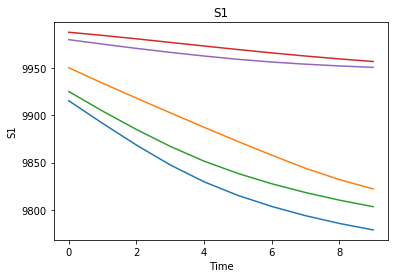

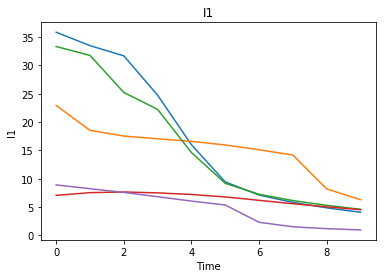

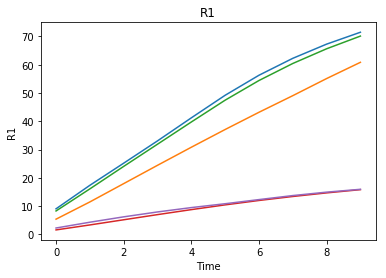

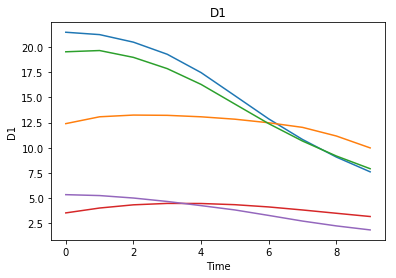

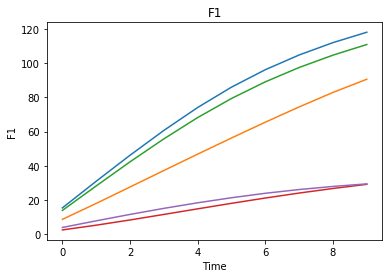

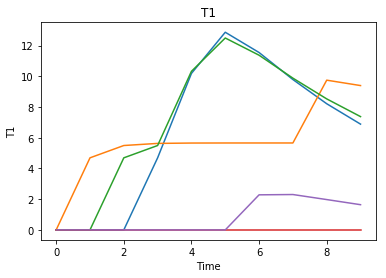

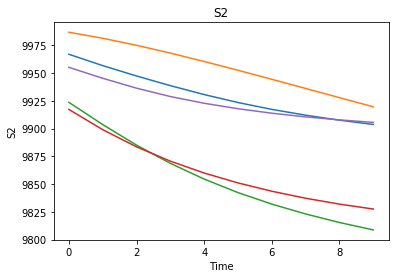

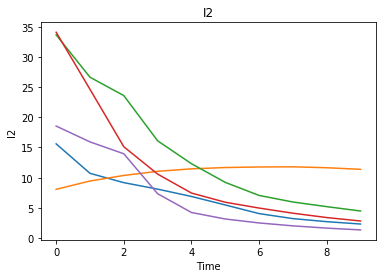

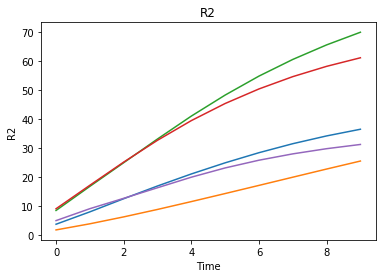

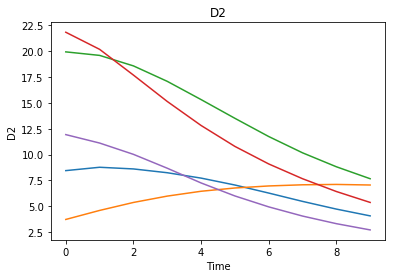

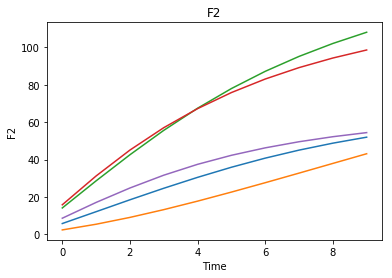

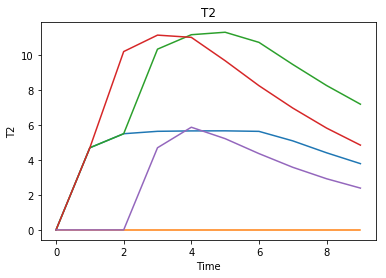

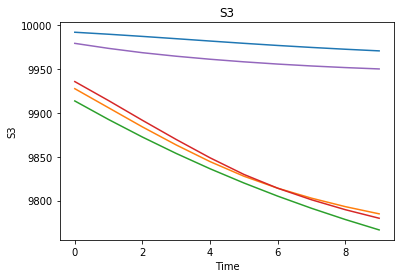

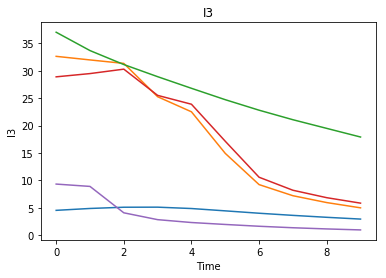

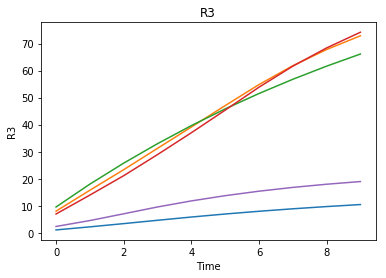

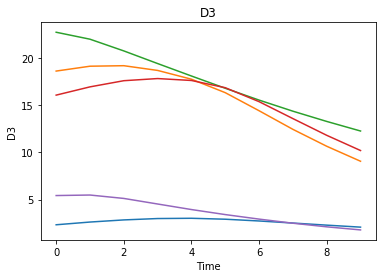

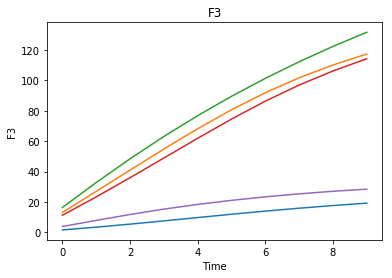

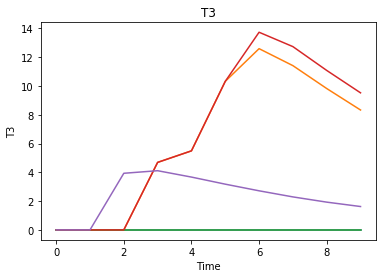

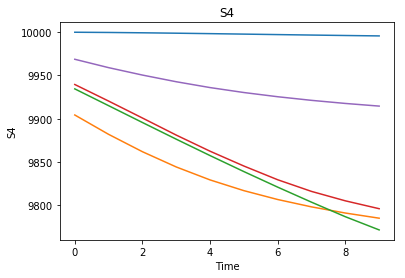

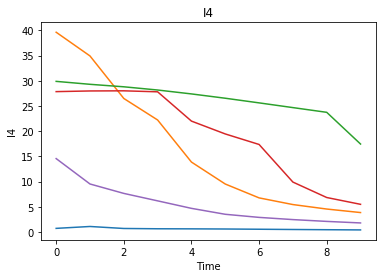

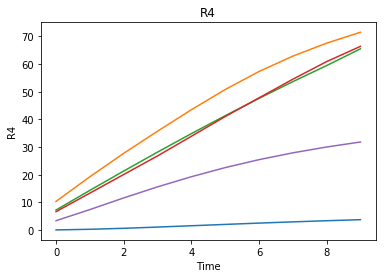

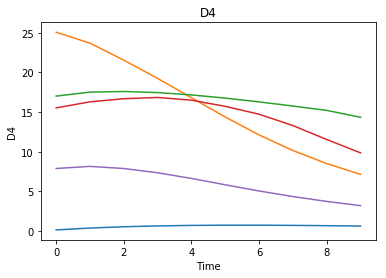

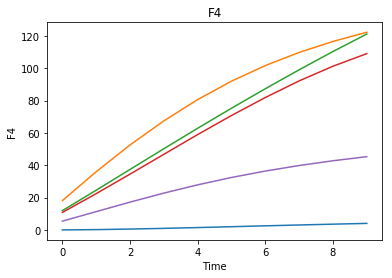

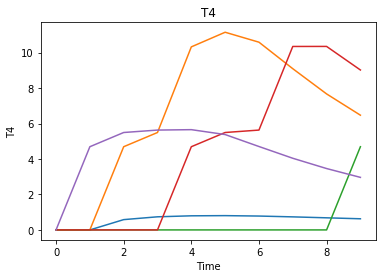

In [33]:
from ema_workbench import SequentialEvaluator

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=5)
    
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes.keys():
    plotting.lines((experiments, outcomes), outcomes_to_show=outcome, 
                   density=False)
plt.show()

1
